Cancer Detection
====

In [1]:
#%pip install -U ipywidgets

In [1]:
import os
import cv2
import time
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

from albumentations.pytorch import ToTensorV2

# pretrained models
import torchvision
from torchvision import models, transforms

from tqdm.notebook import tqdm



Importing the data
====

In [2]:
data_path = '/home/oniemann/Cancer_Classifier/lung_colon_image_set/'

rows = []

for c_type in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{c_type}'):
        print(label)
        for image in os.listdir(data_path + f'/{c_type}/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label

            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{c_type}/{label}'
            if '.jpeg' in row['image_file']:
                rows.append(row)
        
df = pd.DataFrame(rows[1:])
df['image_path'] = df['image_path'].map(lambda x: x.replace("//", "/"))
print(len(df))
df.head()

lung_aca
lung_n
lung_scc
colon_n
colon_aca
24999


,image_file,label,image_path
0,lungaca1843.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...
1,lungaca294.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...
2,lungaca3487.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...
3,lungaca4342.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...
4,lungaca1140.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...


In [3]:
df.label.value_counts()

lung_n       5000
colon_n      5000
lung_scc     5000
colon_aca    5000
lung_aca     4999
Name: label, dtype: int64

# Create Augmented Dataset

- crop

- horizontal/vertical reflection

- rotation

- brightness contrast

In [4]:
class CancerImagesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.label_dict = {label:idx for idx, label in enumerate(df.label.unique())}
        
        # Randomly augment images for variety
        self.transforms = A.Compose([
            # spatial transforms
            A.RandomCrop(width=255, height=255),
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, 
                     border_mode = cv2.BORDER_CONSTANT, 
                     value = 0.0, p = .75),

            # pixel-level transformation
            A.RandomBrightnessContrast(p=0.1),

            # we will normalize according to ImageNet since we will be using a pre-trained ResNet
            # this adjusts from [0,255] to [0,1]
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

            # convert to a tensor and move color channels
            ToTensorV2()
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path = row['image_path'] + f"/{row['image_file']}"

        img = cv2.imread(path)

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        #Scale to v
        img = ((img - img.min()) / (img.max()-img.min()))
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [5]:
!pwd

/home/oniemann/Cancer_Classifier


lung_aca


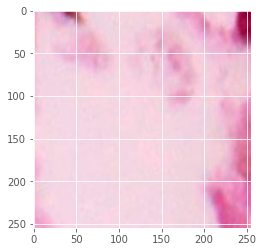

In [6]:
# Example
ds = CancerImagesDataset(df)
translate_back = {v:k for k, v in ds.label_dict.items()}
img = np.transpose(ds[1994][0], (1, 2, 0))
print(translate_back[ds[1994][1].item()])
plt.imshow(img);

- Create data loaders for train/test split

In [7]:
batch_size = 16

df_train, df_test = train_test_split(df)
df_train, df_valid = train_test_split(df_train)

ds_train = CancerImagesDataset(df_train)
ds_valid = CancerImagesDataset(df_valid)

dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size = batch_size, shuffle=False)

# Identify Best Pretrained CNN Model:

- The following code was used to test different baseline models from the torchvision model library.
- Models tested: resnet18, densenet121, mobilenet_v2, alexnet

In [10]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [12]:
today = str(date.today())
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 5, bias=True)

## model

In [14]:
# from torchsummary import summary
# summary(model, input_size = (3, 400, 400), device='cpu')

In [15]:
# for param in resnet.parameters():
#             param.requires_grad = False
        
# resnet.fc = nn.Linear(512, 4, bias = True)

# for name, param in resnet.named_parameters():
#     print(f"{name} gradient is set to", param.requires_grad)

In [16]:
!cd models

In [28]:
directory = 'densenet121'
!mkdir /home/oniemann/Cancer_Classifier/models/$directory
!mkdir /home/oniemann/Cancer_Classifier/models/$directory/model_checkpoints

mkdir: cannot create directory ‘/home/oniemann/Cancer_Classifier/models/densenet121’: File exists
mkdir: cannot create directory ‘/home/oniemann/Cancer_Classifier/models/densenet121/model_checkpoints’: File exists


# Training Loop

In [26]:
torch.cuda.is_available()
#!nvidia-smi

True

In [25]:
device = torch.device(0)
model.to(device)
print("model successfully made it onto GPU")

model successfully made it onto GPU


In [7]:
def one_pass(model, dataloader, optimizer, lossFun, lrs, idx, backwards=True, print_loss=False):
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        #if backwards == True:
            #lr = lrs[idx]
            #update_optimizer(optimizer, lr)
            
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss, idx

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

# Training the Single Multi-Class Model:

- The following cells were used to both identify the best pretrained baseline model and act as a representative for future baseline multi-class tasks

In [31]:
lossFun = nn.CrossEntropyLoss()

params_to_update = []

for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

num_epochs = 10
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

iterations = num_epochs*len(dl_train)
lrs = get_cosine_triangular_lr(max_lr=0.01, iterations=iterations)
idx = 0

for i, epoch in tqdm(enumerate(range(num_epochs))):
    print('Epoch: ', epoch)
    
    train_loss, idx = one_pass(model, dl_train, optimizer, lossFun, lrs, idx)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss, idx = one_pass(model, dl_valid, optimizer, lossFun, lrs=None, idx=idx, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_valid, len(ds_valid))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    # Save model for the epoch
    model_name = f'models/{directory}/{today}_epoch_{epoch}_tacc_{train_acc:.2f}_vacc_{valid_acc:.2f}.pkl'
    pickle.dump(model, open(model_name, 'wb'))
    
    # Parameter Checkpoint
    checkpoint = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, f'models/{directory}/model_checkpoints/{today}_epoch_{epoch}.pt')

0it [00:00, ?it/s]

Epoch:  0


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.7565150805945011


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  7.847371351189988
Train Acc:  0.6966787568451747
Valid Acc:  0.028156996587030747
Epoch:  1


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.4525623443420972


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  8.709438563206904
Train Acc:  0.8517175165350971
Valid Acc:  0.1772610921501706
Epoch:  2


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.3726421116901068


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  10.23386074984033
Train Acc:  0.7811677690064718
Valid Acc:  0.09087030716723554
Epoch:  3


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.3475946295493631


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  10.436436739391027
Train Acc:  0.8229855629044875
Valid Acc:  0.1710750853242321
Epoch:  4


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.32152573057620937


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  11.615591351896423
Train Acc:  0.824407936846597
Valid Acc:  0.1715017064846417
Epoch:  5


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.30416974107882133


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  10.56379355993694
Train Acc:  0.9084702368252614
Valid Acc:  0.20968430034129693
Epoch:  6


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.2777005713814456


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  11.58653934823775
Train Acc:  0.8539221961453667
Valid Acc:  0.2037116040955631
Epoch:  7


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.27386252147244106


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  9.52670332026563
Train Acc:  0.749662186188749
Valid Acc:  0.10174914675767921
Epoch:  8


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.24962360047193857


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  20.374847607401044
Train Acc:  0.5340302965649669
Valid Acc:  0.2239761092150171
Epoch:  9


  0%|          | 0/879 [00:00<?, ?it/s]

Train loss:  0.25939175018890254


  0%|          | 0/293 [00:00<?, ?it/s]

Valid loss:  9.988693709259554
Train Acc:  0.9085413555223668
Valid Acc:  0.20904436860068254


Deciding on model architecture:
====

- Strategy 1: Train a single model with all classes (lung_aca, lung_scc, lung_n, colon_aca, colon_n)

- Strategy 2: Train one model to detect lung cancer (lung_aca, lung_scc, lung_n) and another to detect colon cancer (colon_aca, colon_n).
    - Assumption: In production, the model will be given labels differentiating colon tissue xrays from lung tissue xrays

In [ ]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Linear(1024, 5, bias=True)

Strategy 2: Two Models
----

- We first need to split the data into two sets by image location (colon, lung):

In [8]:
df['location'] = df['label'].map(lambda x: x.split("_")[0])
df_lung = df[df['location'] == 'lung']
df_colon = df[df['location'] == 'colon']

- one pass was updated so that loss and accuracy are trained in the same loop (computational efficiency)

In [24]:
lung_train, lung_valid = train_test_split(df_lung)
lung_train['label'].value_counts()

lung_train_ds = CancerImagesDataset(lung_train)
lung_train_dl = DataLoader(lung_train_ds, batch_size=16)

lung_valid_ds = CancerImagesDataset(lung_valid)
lung_valid_dl = DataLoader(lung_valid_ds, batch_size=16)

In [25]:
colon_train, colon_valid = train_test_split(df_colon)
colon_train['label'].value_counts()

colon_train_ds = CancerImagesDataset(colon_train)
colon_train_dl = DataLoader(colon_train_ds, batch_size=16)

colon_valid_ds = CancerImagesDataset(colon_valid)
colon_valid_dl = DataLoader(colon_valid_ds, batch_size=16)

In [18]:
def one_pass_train_valid(model, train_dl, valid_dl, optimizer, lossFun, class_type, device):
    
    model.train()
    
    losses = []
    accuracies = []
    y_preds = []
    for x, y in tqdm(train_dl):    
        x, y = x.to(device), y.to(device)
        
#         print(y.shape)

        y_pred = model(x)
        if class_type == 'binary':
            y = y.float()
            y_pred = y_pred.squeeze()

        loss = lossFun(y_pred, y)
        losses.append(loss.item())
        
        if class_type == 'binary':
            y_pred = nn.Sigmoid()(y_pred)
            y_pred[y_pred >= 0.5] = 1.
            y_pred[y_pred<0.5] = 0.

        else:
            y_pred = torch.argmax(y_pred, dim=1)

    
        acc = (y_pred == y).sum() / len(y)
        accuracies.append(acc.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    train_acc = sum(accuracies) / len(accuracies)
    train_loss = sum(losses) / len(losses)
    
    model.eval()
    
    losses = []
    accuracies = []
    
    for x, y in tqdm(valid_dl):
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        if class_type == 'binary':
            y = y.float()
            y_pred = y_pred.squeeze()
            
        loss = lossFun(y_pred, y)
        losses.append(loss.item())
        
        if class_type == 'binary':
            y_pred = nn.Sigmoid()(y_pred)
            y_pred[y_pred >= 0.5] = 1.
            y_pred[y_pred<0.5] = 0.

        else:
            y_pred = torch.argmax(y_pred, dim=1)

        acc = (y_pred == y).sum() / len(y)
        accuracies.append(acc.item())
        
    valid_acc = sum(accuracies) / len(accuracies)
    valid_loss = sum(losses) / len(losses)
    
    return train_loss, train_acc, valid_loss, valid_acc

Model 1: Lung Cancer Classifier (Multi-Class Classification)
----

In [68]:
torch.cuda.memory_cached()

/home/oniemann/deep_learning/lib64/python3.6/site-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


2139095040

In [48]:
# lung_model = models.resnet18(pretrained=True)
# lung_model.fc = nn.Linear(512, 3)

# device = torch.device(0)
# lung_model.to(device)

lossFun = nn.CrossEntropyLoss()

params_to_update = []

for param in lung_model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

num_epochs = 5
# tl1 = []
# vl1 = []
# ta1 = []
# va1 = []

for i in tqdm(range(num_epochs)):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(lung_model, lung_train_dl, lung_valid_dl, optimizer, lossFun, class_type='multiclass', device=device)
    tl1.append(train_loss)
    vl1.append(valid_loss)
    ta1.append(train_acc)
    va1.append(valid_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Model 2: Colon Cancer Classifier (Binary Classification)
----

In [49]:
# colon_model = models.resnet18(pretrained=True)
# colon_model.fc = nn.Linear(512, 1)

# device = torch.device(0)
# colon_model.to(device)

lossFun = nn.BCEWithLogitsLoss()

params_to_update = []

for param in colon_model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

# tl2 = []
# vl2 = []
# ta2 = []
# va2 = []

for i in range(num_epochs):
    one_pass_train_valid(colon_model, colon_train_dl, colon_valid_dl, optimizer, lossFun, class_type='binary', device=device)
    tl2.append(train_loss)
    vl2.append(valid_loss)
    ta2.append(train_acc)
    va2.append(valid_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [35]:
def avg_loss(l_colon, l_lung):
    return [(i+j)/2 for i, j in zip(l_colon, l_lung)]

def avg_acc(acc_colon, acc_lung, len_df_colon, len_df_lung):
    return [((len_df_colon) * i + (len_df_lung) * j)/(len_df_colon + len_df_lung) for i, j in zip(acc_colon, acc_lung)]

In [50]:
train_loss = avg_loss(tl1, tl2)
valid_loss = avg_loss(vl1, vl2)
train_acc = avg_acc(ta1, ta2, len(colon_train), len(lung_train))
valid_acc = avg_acc(va1, va2, len(colon_valid), len(lung_valid))

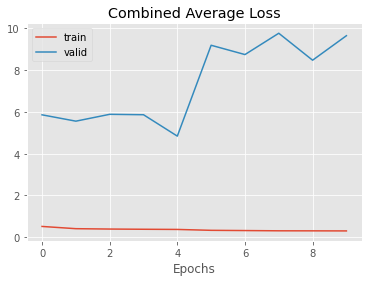

In [51]:
plt.plot(train_loss, label = 'train')
plt.plot(valid_loss, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Combined Average Loss')
plt.savefig('figures/combined_average_loss.png')

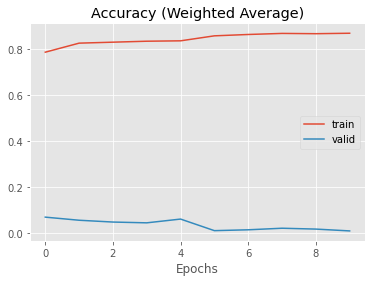

In [52]:
plt.plot(train_acc, label = 'train')
plt.plot(valid_acc, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy (Weighted Average)')
plt.savefig('figures/combined_average_accuracy.png')

- As seen in the above figure, we're still running into the problem of a highly overfit model.

# Transform the Task into Binary Classification (Presence of Cancer):

- Since the model is failing miserably in terms of generalization, maybe it's a good idea to take a few steps back and solely focus on whether an image can be predicted to contain cancer.

In [7]:
model = models.resnet18(pretrained=True)
device = torch.device(0)
model.fc = nn.Linear(512, 1, bias=True)
model.to(device)
print()

In [10]:
df['type'] = df['label'].map(lambda x: 'Not Cancer' if 'n' in x.split('_')[1] else 'Cancer')
df['type'].value_counts()

Cancer        14999
Not Cancer    10000
Name: type, dtype: int64

In [15]:
class BinCancerImagesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.label_dict = {label:idx for idx, label in enumerate(df.type.unique())}
        
        # Randomly augment images for variety
        self.transforms = A.Compose([
            # spatial transforms
            A.RandomCrop(width=255, height=255),
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, 
                     border_mode = cv2.BORDER_CONSTANT, 
                     value = 0.0, p = .75),

            # pixel-level transformation
            A.RandomBrightnessContrast(p=0.1),

            # we will normalize according to ImageNet since we will be using a pre-trained ResNet
            # this adjusts from [0,255] to [0,1]
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

            # convert to a tensor and move color channels
            ToTensorV2()
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path = row['image_path'] + f"/{row['image_file']}"
        
        img = cv2.imread(path)
        
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        #Scale to v
        img = ((img - img.min()) / (img.max()-img.min()))
        
        label = torch.tensor(self.label_dict[row['type']])
        
        return img, label

In [10]:
train_df, valid_df = train_test_split(df)

In [11]:
train_ds = BinCancerImagesDataset(train_df)
valid_ds = BinCancerImagesDataset(valid_df)

batch_size= 30
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [16]:
model = models.resnet18(pretrained=True)
device = torch.device(0)
model.fc = nn.Linear(512, 1, bias=True)
model.to(device)

lossFun = nn.BCEWithLogitsLoss()

params_to_update = []

for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

tl_bin = []
vl_bin = []
ta_bin = []
va_bin = []
num_epochs = 10

for i in range(num_epochs):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(model, train_dl, valid_dl, optimizer, lossFun, class_type='binary', device=device)
    print(f"train_acc: {train_acc:.4f},  valid_acc = {valid_acc:.4f}")
    tl_bin.append(train_loss)
    vl_bin.append(valid_loss)
    ta_bin.append(train_acc)
    va_bin.append(valid_acc)
    model_name = f'models/resnet18/8112021_epoch_{i}_tacc_{train_acc:.3f}_vacc_{valid_acc:.3f}.pkl'
    pickle.dump(model, open(model_name, 'wb'))

  0%|          | 0/625 [00:00<?, ?it/s]

/home/oniemann/deep_learning/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.8454,  valid_acc = 0.8094


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.8884,  valid_acc = 0.6577


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9139,  valid_acc = 0.9070


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9281,  valid_acc = 0.8707


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9307,  valid_acc = 0.8799


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9356,  valid_acc = 0.9185


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9447,  valid_acc = 0.6108


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9456,  valid_acc = 0.9116


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9513,  valid_acc = 0.9596


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9530,  valid_acc = 0.8482


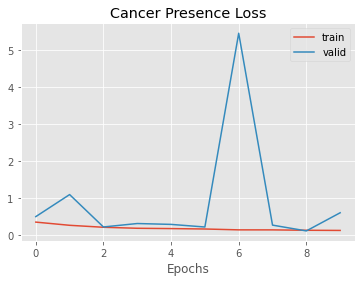

In [17]:
plt.plot(tl_bin, label = 'train')
plt.plot(vl_bin, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Cancer Presence Loss')
plt.savefig('figures/cancer_yes_no_loss.png')

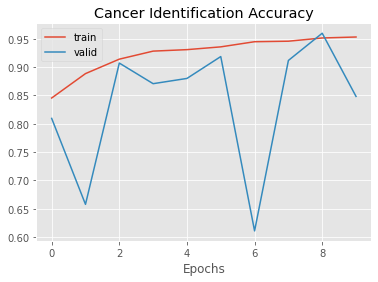

In [18]:
plt.plot(ta_bin, label = 'train')
plt.plot(va_bin, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Cancer Identification Accuracy')
plt.savefig('figures/cancer_identification_accuracy.png')

- Wow, cancer identification is incredible when turned into a binary classification problem! Let's see how the model performs as a multi-classification task on the different cancers.

# Fine-Tuning the Model:

- Every five epochs, unfreeze a single layer (and its bias terms)
- Stop when there is no significant gain in the model's accuracy

In [26]:
filename = './models/resnet18/8112021_epoch_9_tacc_0.953_vacc_0.848.pkl'
ft_model = pickle.load(open(filename, 'rb'))

In [30]:
for idx, (i, l) in enumerate(ft_model.named_parameters()):
    if idx > 57:
        l.requires_grad = True
    print(idx, i, l.requires_grad)

params_to_update = []

for param in ft_model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

0 conv1.weight False
1 bn1.weight False
2 bn1.bias False
3 layer1.0.conv1.weight False
4 layer1.0.bn1.weight False
5 layer1.0.bn1.bias False
6 layer1.0.conv2.weight False
7 layer1.0.bn2.weight False
8 layer1.0.bn2.bias False
9 layer1.1.conv1.weight False
10 layer1.1.bn1.weight False
11 layer1.1.bn1.bias False
12 layer1.1.conv2.weight False
13 layer1.1.bn2.weight False
14 layer1.1.bn2.bias False
15 layer2.0.conv1.weight False
16 layer2.0.bn1.weight False
17 layer2.0.bn1.bias False
18 layer2.0.conv2.weight False
19 layer2.0.bn2.weight False
20 layer2.0.bn2.bias False
21 layer2.0.downsample.0.weight False
22 layer2.0.downsample.1.weight False
23 layer2.0.downsample.1.bias False
24 layer2.1.conv1.weight False
25 layer2.1.bn1.weight False
26 layer2.1.bn1.bias False
27 layer2.1.conv2.weight False
28 layer2.1.bn2.weight False
29 layer2.1.bn2.bias False
30 layer3.0.conv1.weight False
31 layer3.0.bn1.weight False
32 layer3.0.bn1.bias False
33 layer3.0.conv2.weight False
34 layer3.0.bn2.weight F

In [32]:
tlft_bin = []
vlft_bin = []
taft_bin = []
vaft_bin = []
num_epochs = 10

for i in range(10, 10+num_epochs):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(ft_model, train_dl, valid_dl, optimizer, lossFun, class_type='binary', device=device)
    print(f"train_acc: {train_acc:.4f},  valid_acc = {valid_acc:.4f}")
    tlft_bin.append(train_loss)
    vlft_bin.append(valid_loss)
    taft_bin.append(train_acc)
    vaft_bin.append(valid_acc)
    model_name = f'models/resnet18/8112021_epoch_{i}_tacc_{train_acc:.3f}_vacc_{valid_acc:.3f}.pkl'
    pickle.dump(ft_model, open(model_name, 'wb'))

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9618,  valid_acc = 0.9742


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9635,  valid_acc = 0.9729


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9647,  valid_acc = 0.9730


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9625,  valid_acc = 0.9710


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9634,  valid_acc = 0.9758


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9663,  valid_acc = 0.9721


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9643,  valid_acc = 0.9721


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9637,  valid_acc = 0.9711


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9666,  valid_acc = 0.9748


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9658,  valid_acc = 0.9750


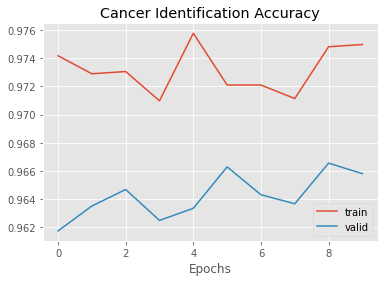

In [57]:
plt.plot(vaft_bin, label = 'train')
plt.plot(taft_bin, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Cancer Identification Accuracy')
plt.savefig('figures/cancer_identification_accuracy_ft.png')

In [50]:
taft2_bin = taft_bin[:5].copy()
vaft2_bin = vaft_bin[:5].copy()

In [51]:
filename = './models/resnet18/8112021_epoch_14_tacc_0.963_vacc_0.976.pkl'
ft2_model = pickle.load(open(filename, 'rb'))

for idx, (i, l) in enumerate(ft2_model.named_parameters()):
    if idx > 56:
        l.requires_grad = True
    print(idx, i, l.requires_grad)

params_to_update = []

for param in ft_model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.001)

0 conv1.weight False
1 bn1.weight False
2 bn1.bias False
3 layer1.0.conv1.weight False
4 layer1.0.bn1.weight False
5 layer1.0.bn1.bias False
6 layer1.0.conv2.weight False
7 layer1.0.bn2.weight False
8 layer1.0.bn2.bias False
9 layer1.1.conv1.weight False
10 layer1.1.bn1.weight False
11 layer1.1.bn1.bias False
12 layer1.1.conv2.weight False
13 layer1.1.bn2.weight False
14 layer1.1.bn2.bias False
15 layer2.0.conv1.weight False
16 layer2.0.bn1.weight False
17 layer2.0.bn1.bias False
18 layer2.0.conv2.weight False
19 layer2.0.bn2.weight False
20 layer2.0.bn2.bias False
21 layer2.0.downsample.0.weight False
22 layer2.0.downsample.1.weight False
23 layer2.0.downsample.1.bias False
24 layer2.1.conv1.weight False
25 layer2.1.bn1.weight False
26 layer2.1.bn1.bias False
27 layer2.1.conv2.weight False
28 layer2.1.bn2.weight False
29 layer2.1.bn2.bias False
30 layer3.0.conv1.weight False
31 layer3.0.bn1.weight False
32 layer3.0.bn1.bias False
33 layer3.0.conv2.weight False
34 layer3.0.bn2.weight F

In [52]:
num_epochs = 5

for i in range(15, 15+num_epochs):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(ft2_model, train_dl, valid_dl, optimizer, lossFun, class_type='binary', device=device)
    print(f"train_acc: {train_acc:.4f},  valid_acc = {valid_acc:.4f}")
#     tlft_bin.append(train_loss)
#     vlft_bin.append(valid_loss)
    taft2_bin.append(train_acc)
    vaft2_bin.append(valid_acc)
    model_name = f'models/resnet18/8112021_epoch_{i}_tacc_{train_acc:.3f}_vacc_{valid_acc:.3f}.pkl'
    pickle.dump(ft_model, open(model_name, 'wb'))

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9652,  valid_acc = 0.9689


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9648,  valid_acc = 0.9703


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9648,  valid_acc = 0.9707


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9642,  valid_acc = 0.9711


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9626,  valid_acc = 0.9750


In [53]:
# filename = './models/resnet18/8112021_epoch_14_tacc_0.963_vacc_0.976.pkl'
# ft2_model = pickle.load(open(filename, 'rb'))

for idx, (i, l) in enumerate(ft2_model.named_parameters()):
    if idx > 54:
        l.requires_grad = True
    print(idx, i, l.requires_grad)

params_to_update = []

for param in ft_model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.001)

0 conv1.weight False
1 bn1.weight False
2 bn1.bias False
3 layer1.0.conv1.weight False
4 layer1.0.bn1.weight False
5 layer1.0.bn1.bias False
6 layer1.0.conv2.weight False
7 layer1.0.bn2.weight False
8 layer1.0.bn2.bias False
9 layer1.1.conv1.weight False
10 layer1.1.bn1.weight False
11 layer1.1.bn1.bias False
12 layer1.1.conv2.weight False
13 layer1.1.bn2.weight False
14 layer1.1.bn2.bias False
15 layer2.0.conv1.weight False
16 layer2.0.bn1.weight False
17 layer2.0.bn1.bias False
18 layer2.0.conv2.weight False
19 layer2.0.bn2.weight False
20 layer2.0.bn2.bias False
21 layer2.0.downsample.0.weight False
22 layer2.0.downsample.1.weight False
23 layer2.0.downsample.1.bias False
24 layer2.1.conv1.weight False
25 layer2.1.bn1.weight False
26 layer2.1.bn1.bias False
27 layer2.1.conv2.weight False
28 layer2.1.bn2.weight False
29 layer2.1.bn2.bias False
30 layer3.0.conv1.weight False
31 layer3.0.bn1.weight False
32 layer3.0.bn1.bias False
33 layer3.0.conv2.weight False
34 layer3.0.bn2.weight F

In [54]:
num_epochs = 10

for i in range(20, 20+num_epochs):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(ft2_model, train_dl, valid_dl, optimizer, lossFun, class_type='binary', device=device)
    print(f"train_acc: {train_acc:.4f},  valid_acc = {valid_acc:.4f}")
#     tlft_bin.append(train_loss)
#     vlft_bin.append(valid_loss)
    taft2_bin.append(train_acc)
    vaft2_bin.append(valid_acc)
    model_name = f'models/resnet18/8112021_epoch_{i}_tacc_{train_acc:.3f}_vacc_{valid_acc:.3f}.pkl'
    pickle.dump(ft_model, open(model_name, 'wb'))

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9646,  valid_acc = 0.9705


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9631,  valid_acc = 0.9735


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9649,  valid_acc = 0.9710


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9654,  valid_acc = 0.9721


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9624,  valid_acc = 0.9713


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9651,  valid_acc = 0.9703


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9642,  valid_acc = 0.9726


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9652,  valid_acc = 0.9738


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9649,  valid_acc = 0.9735


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

train_acc: 0.9635,  valid_acc = 0.9729


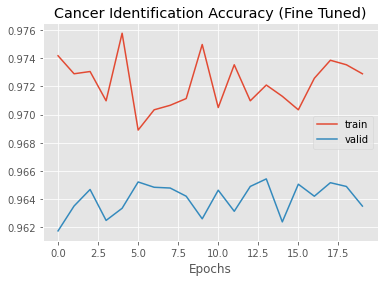

In [59]:
plt.plot(vaft2_bin, label = 'train')
plt.plot(taft2_bin, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Cancer Identification Accuracy (Fine Tuned)')
plt.savefig('figures/cancer_identification_accuracy_ft2.png')

# Scenario Two: Binary Classifier For Lung, Colon

Making Predictions:
----

- The accuracy will be weighed by the number of predictions for each dataset:

$$accuracy = \frac{len(colon_{valid}) * acc_{colon} + len(lung_{valid}) * acc_{lung}}{len(colon_{valid})+len(lung_{valid})} $$

In [11]:
df['location'] = df['label'].map(lambda x: x.split("_")[0])
df_lung = df[df['location'] == 'lung']
df_colon = df[df['location'] == 'colon']
df['type'] = df['label'].map(lambda x: 'Not Cancer' if 'n' in x.split('_')[1] else 'Cancer')
df['type'].value_counts()

Cancer        14999
Not Cancer    10000
Name: type, dtype: int64

## Lung Classifier:

In [12]:
df_lung.head()

,image_file,label,image_path,location,type
0,lungaca1843.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...,lung,Cancer
1,lungaca294.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...,lung,Cancer
2,lungaca3487.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...,lung,Cancer
3,lungaca4342.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...,lung,Cancer
4,lungaca1140.jpeg,lung_aca,/home/oniemann/Cancer_Classifier/lung_colon_im...,lung,Cancer


In [13]:
df_lung['type'].value_counts()

Cancer        9999
Not Cancer    5000
Name: type, dtype: int64

In [16]:
train_df, valid_df = train_test_split(df_lung)

train_ds = BinCancerImagesDataset(train_df)
valid_ds = BinCancerImagesDataset(valid_df)

batch_size= 30
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [19]:
model_lung = models.resnet18(pretrained=True)
device = torch.device(0)
model_lung.fc = nn.Linear(512, 1, bias=True)
model_lung.to(device)

lossFun = nn.BCEWithLogitsLoss()

params_to_update = []

for param in model_lung.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

tl_bin = []
vl_bin = []
ta_bin = []
va_bin = []
num_epochs = 10

for i in range(num_epochs):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(model_lung, train_dl, valid_dl, optimizer, lossFun, class_type='binary', device=device)
    print(f"train_acc: {train_acc:.4f},  valid_acc = {valid_acc:.4f}")
    tl_bin.append(train_loss)
    vl_bin.append(valid_loss)
    ta_bin.append(train_acc)
    va_bin.append(valid_acc)
    #model_name = f'models/resnet18/8112021_epoch_{i}_tacc_{train_acc:.3f}_vacc_{valid_acc:.3f}.pkl'
    #pickle.dump(model, open(model_name, 'wb'))

  0%|          | 0/375 [00:00<?, ?it/s]

/home/oniemann/deep_learning/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9378,  valid_acc = 0.9781


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9732,  valid_acc = 0.9781


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9765,  valid_acc = 0.8549


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9751,  valid_acc = 0.9725


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9772,  valid_acc = 0.9813


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9784,  valid_acc = 0.9803


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9778,  valid_acc = 0.9861


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9845,  valid_acc = 0.9896


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9859,  valid_acc = 0.9915


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

train_acc: 0.9865,  valid_acc = 0.9736


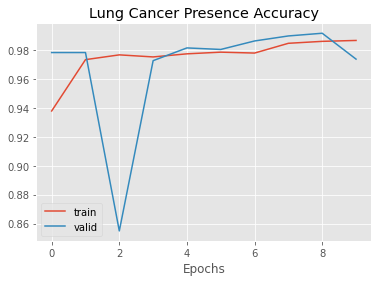

In [20]:
plt.plot(ta_bin, label = 'train')
plt.plot(va_bin, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Lung Cancer Presence Accuracy')
plt.savefig('figures/lung_cancer_acc.png')

## Colon Classifier:

In [80]:
train_df, valid_df = train_test_split(df_colon)

train_ds = BinCancerImagesDataset(train_df)
valid_ds = BinCancerImagesDataset(valid_df)

batch_size= 30
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [81]:
model_colon = models.resnet18(pretrained=True)
device = torch.device(0)
model_colon.fc = nn.Linear(512, 1, bias=True)
model_colon.to(device)

lossFun = nn.BCEWithLogitsLoss()

params_to_update = []

for param in model_colon.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

tl_bin = []
vl_bin = []
ta_bin = []
va_bin = []
num_epochs = 10

for i in range(num_epochs):
    train_loss, train_acc, valid_loss, valid_acc = one_pass_train_valid(model_colon, train_dl, valid_dl, optimizer, lossFun, class_type='binary', device=device)
    print(f"train_acc: {train_acc:.4f},  valid_acc = {valid_acc:.4f}")
    tl_bin.append(train_loss)
    vl_bin.append(valid_loss)
    ta_bin.append(train_acc)
    va_bin.append(valid_acc)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.7680,  valid_acc = 0.4298


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.8555,  valid_acc = 0.5103


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.8788,  valid_acc = 0.4929


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.8963,  valid_acc = 0.4151


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.9099,  valid_acc = 0.4869


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.9188,  valid_acc = 0.4909


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.9251,  valid_acc = 0.4921


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.9153,  valid_acc = 0.2615


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.9241,  valid_acc = 0.4714


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

train_acc: 0.9357,  valid_acc = 0.0913


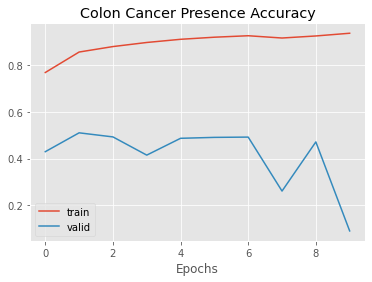

In [82]:
plt.plot(ta_bin, label = 'train')
plt.plot(va_bin, label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.title('Colon Cancer Presence Accuracy')
plt.savefig('figures/colon_cancer_acc.png')

# Loading Parameters/Model

In [28]:
# # now load them up!
# checkpoint = torch.load('model_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [28]:
!pwd

/home/oniemann/Cancer_Classifier
